<a href="https://colab.research.google.com/github/Aouatef-Djeghri/Git-Commands/blob/main/content_based_image_retrieval_pytorch_thisOneX_ray_ALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [1]:
import zipfile
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [2]:
# Additional Dependencies
!pip install barbar torchsummary

# Content Based Image Retrieval (CBIR)
## Approach:

- By observing the data its pretty clear that an Unsupervised along with couple of different Hashing approachs will be the most commendable. Although there are number of techniques in that area as well, we'll focus on Auto-Encoder technique:
    
    - ***Latent Feature Extraction***: In this technique we can find feature vectors for every image by creating hooks on a pre-trained network and extracting the vector from previous layers. Other technique devises the use of **AutoEncoders** where the Latent features can be extracted from Encoder itself. For the sake of this data we'll proceed with AutoEncoders. For the retrieval part we'll look into Euclidean based Search (O(NlogN)) and Hashing Based Approaches (O(logN)).
    <br>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import copy
import pickle
from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [4]:
# Find if any accelerator is presented, if yes switch device to use CUDA or else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
# from PIL import Image

# def make_square(im, min_size=512): 
#     x, y = im.size
#     size = max(min_size, x, y)
#     new_im = Image.new('RGBA', (size, size), (255, 255, 255, 0)) #fill_color=(255, 255, 255, 0) | #fill_color=(0, 0, 0, 0)
#     new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
#     return new_im

# test_image = Image.open('/content/gdrive/My Drive/IRMA X-ray dataset/ImageCLEFmed2009_train.02/10014.png')
# #For a white background you can do:
# test_image = make_square(test_image)

# shape = np.array(test_image).shape
# print(shape)

# w, h = test_image.size
# print('width: ', w)
# print('height:', h)




In [5]:
# preparing intermediate DataFrame
datasetPath = Path('/content/gdrive/MyDrive/IRMA X-ray dataset/New IRMA X-Ray dataset/ImageCLEFmed2009_train.02')
df = pd.DataFrame()

df['image'] = [f for f in os.listdir(datasetPath) if os.path.isfile(os.path.join(datasetPath, f))]
df['image'] = '/content/gdrive/MyDrive/IRMA X-ray dataset/New IRMA X-Ray dataset/ImageCLEFmed2009_train.02/' + df['image'].astype(str)
df.head()

,image
0,/content/gdrive/MyDrive/IRMA X-ray dataset/New...
1,/content/gdrive/MyDrive/IRMA X-ray dataset/New...
2,/content/gdrive/MyDrive/IRMA X-ray dataset/New...
3,/content/gdrive/MyDrive/IRMA X-ray dataset/New...
4,/content/gdrive/MyDrive/IRMA X-ray dataset/New...


# Data Preparation

In [ ]:
def preprocessing(img):
    x, y = img.size
    size = max(512, x, y)
    new_im = Image.new('RGB', (size, size), (0, 0, 0))
    new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [6]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        row = self.dataFrame.iloc[key]
        img = Image.open(row['image'])
        new_img = preprocessing(img)
        image = self.transformations(new_img)
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)

In [7]:
# Intermediate Function to process data from the data retrival class
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.15, random_state=RANDOMSTATE)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    
    return train_set, validate_set

# AutoEncoder Model

## High Level Structure of an AutoEncoder

![](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      stride=3, 
                      padding=1),  # (32,16,171,171)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (N,16,85,85)
            
            nn.Conv2d(in_channels=16, 
                      out_channels=8, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),  # (N,8,43,43)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (N,8,42,42)
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 8, 
                               out_channels=16, 
                               kernel_size=(3,3), 
                               stride=2),  # (N,16,85,85)
            nn.ReLU(True),
 
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=8, 
                               kernel_size=(5,5), 
                               stride=3, 
                               padding=1),  # (N,8,255,255)
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=8, 
                               out_channels=3, 
                               kernel_size=(6,6), 
                               stride=2, 
                               padding=1),  # (N,3,512,512)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
class ConvAutoencoder_v2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_v2, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=0), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2) 
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1,
                              padding=1), 
 
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1, 
                               padding=1),  
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=0),  
            
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1), 
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=3, 
                               kernel_size=(4,4), 
                               stride=2, 
                               padding=2),  
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
summary(ConvAutoencoder_v2().to(device),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 126, 126]         147,584
              ReLU-9        [-1, 128, 126, 126]               0
        MaxPool2d-10          [-1, 128, 63, 63]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

# Training Function

In [11]:
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    #valid_loss_min = checkpoint['valid_loss_min']

    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint
    
def train_model(model,  
                criterion, 
                optimizer, 
                #scheduler, 
                num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for idx,inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='ckpt_epoch_{}.pt'.format(epoch))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

In [12]:
EPOCHS = 150
NUM_BATCHES = 32
RETRAIN = False

train_set, validate_set = prepare_data(DF=df)

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=1) ,
                'val':DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=1)
                }

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

model = ConvAutoencoder_v2().to(device)

criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
# If re-training is required:
# Load the old model
if RETRAIN == True:
    # load the saved checkpoint
    model, optimizer, start_epoch = load_ckpt('/content/gdrive/My Drive/IRMA X-ray dataset/conv_autoencoderv2_200epnewALL.pt', model, optimizer) #../input/cbirpretrained/conv_autoencoder.pt
    print('Checkpoint Loaded')

In [ ]:
model, optimizer, loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    #scheduler=exp_lr_scheduler,
                    num_epochs=EPOCHS)

Epoch 0/150
----------
 3936/10775: [===========>....................] - ETA 19055.0s

In [ ]:
# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/gdrive/My Drive/IRMA X-ray dataset/conv_autoencoderv2_200epnewALL.pt')

# Inference

## 1. Indexing

In [ ]:
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [ ]:
# Load Model in Evaluation phase
model = ConvAutoencoder_v2().to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/IRMA X-ray dataset/conv_autoencoderv2_200epnewALL.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

In [ ]:
def get_latent_features(images, transformations):
    
    latent_features = np.zeros((2000,256,16,16))
    #latent_features = np.zeros((1137,8,42,42))
    
    for i,image in enumerate(tqdm(images)):
        img = Image.open(image)#.convert('RGB')
        new_img = preprocessing(img)
        tensor = transformations(new_img).to(device)
        # tensor = tensor.reshape(1, 1, 512, 303)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [ ]:
images = df.image.values
latent_features = get_latent_features(images, transformations)

100%|██████████| 2000/2000 [13:12<00:00,  2.52it/s]


In [ ]:
indexes = list(range(0, 1600))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [ ]:
# write the data dictionary to disk
#with open('features.pkl', "wb") as f:
#    f.write(pickle.dumps(index_dict))

## 2. Image Retrieval 

<font size="3"> This will be approached with two ways as discussed in the start:
    - Euclidean Search:
        - Identifying the Latent Features
        - Calculating the Euclidean Distance between them
        - Returning the closest N indexes (of images)
    
    - Locality Sensitive Hashing
        - Create hashes of the feature vector from Encoder
        - Store it in a Hashing Table
        - Identify closest images based on hamming distance

### 2.1 Euclidean Search Method

In [ ]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [ ]:
def cosine_distance(a,b):
    return scipy.spatial.distance.cosine(a, b)

In [ ]:
def perform_search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])):
        # compute the euclidean distance between our query features
        # and the features for the current image in our index, then
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]
    # return the list of results
    return results

In [ ]:
def build_montages(image_list, image_shape, montage_shape):

    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

1877
1827
1837
1907
209
1215
245
1355
1202
8


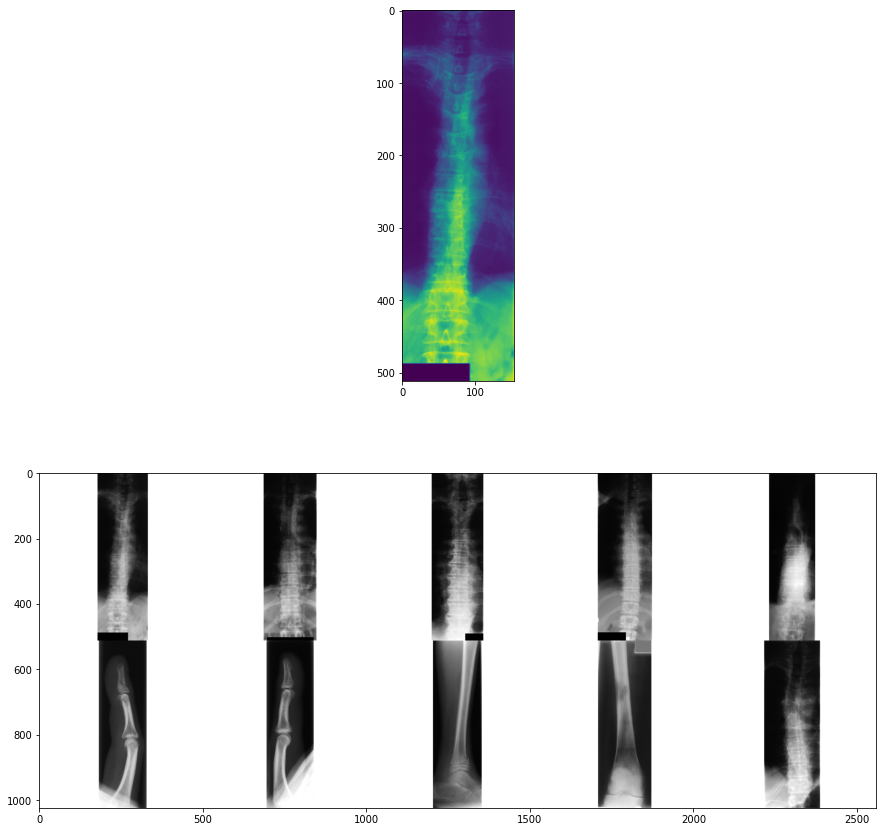

In [ ]:
# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result
# images
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 1877# Input Index for which images 
MAX_RESULTS = 10


queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:

    im = Image.open(images[j])
    new_img = preprocessing(img)
    img = np.array(new_img)
    print(j)
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

In [ ]:
testpath = Path('/content/gdrive/MyDrive/IRMA X-ray dataset/New IRMA X-Ray dataset/ImageCLEFmed2009_test.03')
testdf = pd.DataFrame()

testdf['image'] = [f for f in os.listdir(testpath) if os.path.isfile(os.path.join(testpath, f))]
testdf['image'] = '/content/gdrive/MyDrive/IRMA X-ray dataset/New IRMA X-Ray dataset/ImageCLEFmed2009_test.03/' + testdf['image'].astype(str)

testdf.head()

,image
0,/content/gdrive/MyDrive/IRMA X-ray dataset/Ima...
1,/content/gdrive/MyDrive/IRMA X-ray dataset/Ima...
2,/content/gdrive/MyDrive/IRMA X-ray dataset/Ima...
3,/content/gdrive/MyDrive/IRMA X-ray dataset/Ima...
4,/content/gdrive/MyDrive/IRMA X-ray dataset/Ima...


In [ ]:
testimages = testdf.image.values
test_latent_features = get_latent_features(testimages, transformations)

100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


In [ ]:
test_latent_features.shape

(1883, 256, 16, 16)

5
831
1288
1691
705
266
919
1569
1567
1827


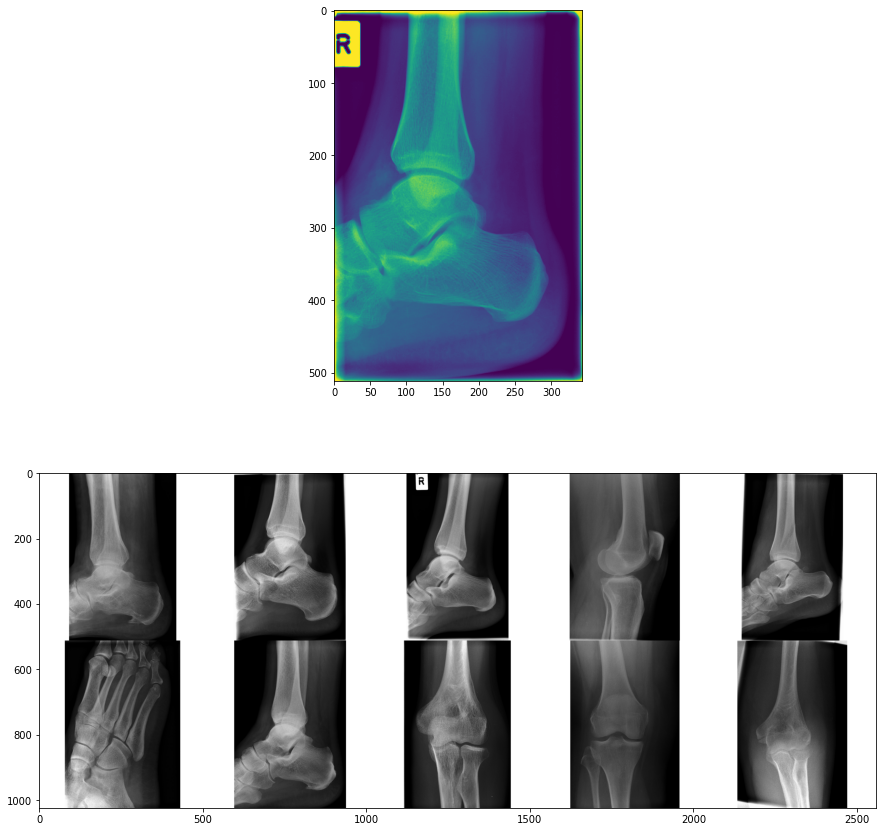

In [ ]:
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
MAX_RESULTS = 10
queryIdx = 1

queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:


    img = Image.open(images[j])
    new_img = preprocessing(img)
    img = np.array(new_img)
    print(j)
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(testimages[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

### 2.2 LSHashing Method

In [ ]:
#!pip install lshashpy3

In [ ]:
#from lshashpy3 import LSHash

In [ ]:
## Locality Sensitive Hashing
# params
# k = 12 # hash size
# L = 5  # number of tables
# d = 14112 # Dimension of Feature vector
# lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# # LSH on all the images
# for idx,vec in tqdm(feature_dict.items()):
#     lsh.index(vec.flatten(), extra_data=idx)

In [ ]:
## Exporting as pickle
#pickle.dump(lsh, open('lsh.p', "wb"))

In [ ]:
# def get_similar_item(idx, feature_dict, lsh_variable, n_items=10):
#     response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
#                      num_results=n_items+1, distance_func='hamming')
    
#     imgs = []
#     for i in range(1, n_items+1):
#         imgs.append(np.array(Image.open(images[response[i][0][1]])))
#     return imgs

In [ ]:
# fig, ax = plt.subplots(nrows=2,figsize=(15,15))
# queryIdx = 5

# ax[0].imshow(np.array(Image.open(images[queryIdx])))

# montage = build_montages(get_similar_item(queryIdx, feature_dict, lsh,10),(512, 512), (5, 2))[0]
# ax[1].imshow(montage)

# End Notes

- We started with the approach of AutoEncoders for Image Latent Features extraction followed by Image retrieval using Euclidean Distance which was an O(NlogN) approach (Time-Complexity) to Hashing which gave us an ~O(logN) approach